#**Ligand Diffusion**

Adapted from
[RFDiffusion](https://colab.research.google.com/github/sokrypton/ColabDesign/blob/v1.1.1/rf/examples/diffusion.ipynb#scrollTo=tSgCPxIZ1T_A)

RFdiffusion is a method for structure generation, with or without conditional information (a motif, target etc). It can perform a whole range of protein design challenges as we have outlined in the RFdiffusion [manuscript](https://www.biorxiv.org/content/10.1101/2022.12.09.519842v2).

**<font color="red">NOTE:</font>** This notebook is in development, we are still working on adding all the options from the manuscript above.

For **instructions**, see end of Notebook.

See [diffusion_foldcond](https://colab.research.google.com/github/sokrypton/ColabDesign/blob/main/rf/examples/diffusion_foldcond.ipynb) for fold conditioning functionality.

See [original version](https://colab.research.google.com/github/sokrypton/ColabDesign/blob/main/rf/examples/diffusion_ori.ipynb) of this notebook (from 31Mar2023).



In [ ]:
!pip install -q biopython
!pip install -q dash jupyter-dash dash-bootstrap-components


In [ ]:

from IPython.display import clear_output

import dash
from dash import html, dcc, Input, Output, State, ctx, MATCH, ALL
import dash_bootstrap_components as dbc

from Bio.PDB import PDBParser, MMCIFParser
import os
import numpy as np
import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State, ALL, MATCH
import dash_bootstrap_components as dbc
from dash import ctx

from plotly import graph_objs as go
import plotly.express as px

In [24]:
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
app.config.suppress_callback_exceptions = True
modes = ["Unconditional", "Binder Design", "Motif Scaffolding", "Partial Diffusion"]

app.layout = dbc.Container(
    [
        html.H3("RFdiffusion Generator"),
        dbc.Label("Select Mode"),
        dcc.Dropdown(modes, id="mode", value="Unconditional"),
        html.Hr(),
        # Dynamic fields
        html.Div(id="form-fields"),
        html.Hr(),
        html.Div(id="segmentFields"),
        html.Hr(),
        html.H4("Run Parameters"),
        dbc.Row(
            [
                dbc.Col(
                    [
                        dbc.Label("Iterations"),
                        dcc.Slider(
                            id="iterations",
                            min=25,
                            max=200,
                            step=25,
                            marks={i: str(i) for i in range(25, 201, 25)},
                            value=50,
                            tooltip={"placement": "bottom", "always_visible": True},
                        ),
                    ],
                    width=4,
                ),
                dbc.Col(
                    [
                        dbc.Label("Number of Designs"),
                        dcc.Slider(
                            id="num-designs",
                            min=1,
                            max=32,
                            step=None,
                            marks={2**i: str(2**i) for i in range(6)},
                            value=1,
                            tooltip={"placement": "bottom", "always_visible": True},
                        ),
                    ],
                    width=4,
                ),
                dbc.Col(
                    [
                        dbc.Label("Visualization"),
                        dcc.Dropdown(
                            id="visualization",
                            options=[
                                {"label": "None", "value": "none"},
                                {"label": "Image", "value": "image"},
                                {"label": "Interactive", "value": "interactive"},
                            ],
                            value="image",
                            clearable=False,
                        ),
                    ],
                    width=4,
                ),
            ]
        ),
        dbc.Row(
            [
                dbc.Col(
                    [
                        dbc.Label("Use Beta Model"),
                        dbc.Checklist(
                            id="use-beta-model",
                            options=[{"label": "Yes", "value": True}],
                            value=[False],
                            inline=True,
                            switch=True,
                        ),
                        dbc.Label(
                            'if you are seeing lots of helices, switch to the "beta" params for a better SSE balance.',
                            style={"font": "0.8em"},
                        ),
                    ],
                    width=4,
                ),
            ]
        ),
        html.Hr(),
        html.Div(id="runButtonSpace"),
        html.Br(),
        html.Br(),
        html.Div(id="output"),
        dcc.Store(id="contigs-list", data=[]),
        dcc.Store(id="chain-list", data=[]),
        dcc.Store(id="pdbGraph", data=[]),
        dcc.Store(
            id="segments-store",
            data=[
                {
                    "segment-type": "none",
                    "free-length": "",
                    "fixed-chain": "",
                    "fixed-range": "",
                }
            ],
        ),
    ]
)


def segment_row(mode, index, segment, chainList):
    # Get values from the index dictionary
    segment_type = segment.get("segment-type", "none")
    free_length = segment.get("free-length", "")
    fixed_chain = segment.get("fixed-chain", "")
    fixed_range = segment.get("fixed-range", "")

    # Set style based on segment type
    free_length_style = {} if segment_type == "free" else {"display": "none"}
    fixed_styles = {} if segment_type == "fixed" else {"display": "none"}
    options = []
    if mode == "Binder Design":
        options = [ 
                {"label": "Select", "value": "none"},
                {"label": "Binder", "value": "free"},
                {"label": "Fixed Chain", "value": "fixed"},
                {"label": "Chain Break", "value": "break"},
                {"label": "Hotspot", "value": "hotspot"},
        ]
    else:
        options = (
            [
                {"label": "Select", "value": "none"},
                {"label": "Free Region", "value": "free"},
                {"label": "Fixed Motif", "value": "fixed"},
                {"label": "Chain Break", "value": "break"},
            ]
        )
    return html.Div(
        id={"type": "segment-row", "index": index},
        children=[
            dbc.Row(
                [
                    dbc.Col(
                        dcc.Dropdown(
                            id={"type": "segment-type", "index": index},
                            options=options,
                            value=segment_type,
                            clearable=False,
                        ),
                        width=2,
                    ),
                    dbc.Col(
                        dbc.Input(
                            id={"type": "free-length", "index": index},
                            type="text",
                            placeholder="Fixed Length or Random Range (e.g. 100 or 100-250)",
                            value=free_length,
                            style=free_length_style,
                        ),
                        width=3,
                    ),
                    dbc.Col(
                        [
                            dcc.Dropdown(
                                id={"type": "fixed-chain", "index": index},
                                options=[
                                    {"label": c, "value": c}
                                    for c in [chain["id"] for chain in chainList]
                                ],
                                placeholder="Chain",
                                value=fixed_chain,
                                style=fixed_styles,
                            ),
                            dbc.Input(
                                id={"type": "fixed-range", "index": index},
                                type="text",
                                placeholder="Fixed Residues (e.g. 10-25)",
                                value=fixed_range,
                                style=fixed_styles,
                            ),
                        ],
                        width=4,
                    ),
                    dbc.Col(
                        dbc.Button(
                            "Delete",
                            id={"type": "delete-segment", "index": index},
                            color="danger",
                            n_clicks=0,
                        ),
                        width=1,
                    ),
                ],
                className="mb-2",
            )
        ],
    )


def scaffoldBuilder(mode,segments, chainList):

    return [
        html.Div(
            [
                html.Div(
                    id="segments-container",
                    children=[
                        dbc.Row(
                            [
                                dbc.Col(dbc.Label("Segment Type"), width=2),
                                dbc.Col(dbc.Label("Generate Length"), width=3),
                                dbc.Col(dbc.Label("Fixed Residues"), width=4),
                            ]
                        )
                    ]
                    + [
                        segment_row(mode,i, seg, chainList) for i, seg in enumerate(segments)
                    ],
                ),
                dbc.Button(
                    "Add Segment",
                    id="add-segment",
                    color="primary",
                    className="mt-2",
                    n_clicks=0,
                ),
                html.Hr(),
                html.H5("Current Contigs String:"),
                html.Div(
                    id="contigs-preview",
                    style={"fontFamily": "monospace", "fontSize": "1.2em"},
                ),
            ]
        )
    ]


@app.callback(
    Output("segments-container", "children"),
    Input("segments-store", "data"),
    Input("chain-list", "data"),
    State("mode", "value"),
)
def render_segments(segments, chainList, mode):
    return [
        dbc.Row(
            [
                dbc.Col(dbc.Label("Segment Type"), width=2),
                dbc.Col(dbc.Label("Generate Length"), width=3),
                dbc.Col(dbc.Label("Fixed Residues"), width=4),
            ]
        )
    ] + [segment_row(mode,i, seg, chainList) for i, seg in enumerate(segments)]


@app.callback(
    Output("segments-store", "data"),
    Output("add-segment", "n_clicks"),
    Output({"type": "delete-segment", "index": ALL}, "n_clicks"),
    Output("contigs-preview", "children"),
    Output("pdb-graph-output", "children"),
    [
        Input("add-segment", "n_clicks"),
        Input({"type": "delete-segment", "index": ALL}, "n_clicks"),
        Input({"type": "segment-type", "index": ALL}, "value"),
        Input({"type": "free-length", "index": ALL}, "value"),
        Input({"type": "fixed-chain", "index": ALL}, "value"),
        Input({"type": "fixed-range", "index": ALL}, "value"),
    ],
    [State("segments-store", "data"), State("pdbGraph", "data")],
    prevent_initial_call=True,
    allow_duplicate=True,
)
def update_segments(
    add_clicks,
    delete_clicks,
    seg_types,
    free_lengths,
    fixed_chains,
    fixed_ranges,
    segments,
    pdb_graph,
):
    triggered = ctx.triggered_id

    if not segments:
        segments = []

    # --- Delete ---
    if (
        np.sum(delete_clicks) > 0
        and isinstance(triggered, dict)
        and triggered["type"] == "delete-segment"
    ):
        segments = [s for s in segments if s["id"] != triggered["index"]]
        for i, seg in enumerate(segments):
            seg["id"] = i
    # --- Add ---
    elif add_clicks > 0 and triggered == "add-segment":
        segments.append(
            {
                "id": len(segments),
                "segment-type": "none",
                "free-length": "",
                "fixed-chain": "",
                "fixed-range": "",
            }
        )
    # --- Update fields ---
    else:
        for i, seg in enumerate(segments):
            seg["id"] = i
            seg["segment-type"] = seg_types[i]
            seg["free-length"] = free_lengths[i]
            seg["fixed-chain"] = fixed_chains[i]
            seg["fixed-range"] = fixed_ranges[i]

    # --- Build preview string ---
    preview_list = []
    for seg in segments:
        if seg["segment-type"] == "free" and seg["free-length"]:
            preview_list.append(f"{seg['free-length']}")
        elif (
            seg["segment-type"] == "fixed" and seg["fixed-chain"] and seg["fixed-range"]
        ):
            preview_list.append(f"{seg['fixed-chain']}{seg['fixed-range']}")
        elif seg["segment-type"] == "break":
            preview_list.append("0 ")
    contig_str = "/".join(preview_list)

    # --- Create PDB visualization with selected residues highlighted ---
    fig = go.Figure()

    # If we have PDB data and segments
    if pdb_graph and segments and len(pdb_graph) > 0 and len(segments) > 0:
        # Create a dictionary of selected regions
        selected_regions = {}
        for seg in segments:
            if (
                seg["segment-type"] == "fixed"
                and seg["fixed-chain"]
                and seg["fixed-range"]
            ):
                chain = seg["fixed-chain"]
                if chain not in selected_regions:
                    selected_regions[chain] = []

                # Parse the range
                try:
                    range_parts = seg["fixed-range"].split("-")
                    if len(range_parts) == 2:
                        start = int(range_parts[0])
                        end = int(range_parts[1])
                        selected_regions[chain].extend(list(range(start, end + 1)))
                    elif len(range_parts) == 1:
                        value = int(range_parts[0])
                        selected_regions[chain].append(value)
                except:
                    pass

        # Plot each chain
        for chain_id, coords, indexes in pdb_graph:
            coords = np.array(coords)
            # Plot the whole chain in gray
            fig.add_trace(
                go.Scatter3d(
                    x=coords[:, 0],
                    y=coords[:, 1],
                    z=coords[:, 2],
                    mode="lines",
                    name=f"Chain {chain_id}",
                    line=dict(color="lightgray", width=4),
                    showlegend=True,
                )
            )

            # Find selected residues in this chain
            if chain_id in selected_regions and selected_regions[chain_id]:
                selected_points = []
                for i, index in enumerate(indexes):
                    parts = index.split("_")
                    if len(parts) == 2:
                        res_id = int(parts[1])
                        if res_id in selected_regions[chain_id]:
                            selected_points.append(i)

                if selected_points:
                    selected_coords = coords[selected_points]
                    fig.add_trace(
                        go.Scatter3d(
                            x=selected_coords[:, 0],
                            y=selected_coords[:, 1],
                            z=selected_coords[:, 2],
                            mode="markers+lines",
                            name=f"Selected {chain_id}",
                            marker=dict(color="red", size=6),
                            line=dict(color="red", width=6),
                            showlegend=True,
                        )
                    )

        fig.update_layout(
            width=300,
            height=300,
            margin=dict(l=0, r=0, t=0, b=0),
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False),
            ),
        )

    return (
        segments,
        0,
        [0] * len(delete_clicks),
        contig_str,
        dcc.Graph(figure=fig, style={"height": "300px", "width": "300px"}),
    )


@app.callback(
    Output("form-fields", "children"),
    Output("runButtonSpace", "children"),
    Input("mode", "value"),
)
def display_fields(mode):

    base_fields = []
    instruction_text = ""
    if mode == "Binder Design":
        instruction_text = "Load the protein structure you wish to design a binder for. The PDB file should contain the target protein."
    elif mode == "Motif Scaffolding":
        instruction_text = "Load the protein structure you wish to scaffold. The PDB file should contain the target protein or the motif you wish to scaffold."
    elif mode == "Partial Diffusion":
        instruction_text = "Load the protein structure from which you would like to create variations. "
    if mode in ["Binder Design", "Motif Scaffolding", "Partial Diffusion"]:
        base_fields.extend(
            [
                dbc.Row(
                    [
                        dbc.Col(
                            [
                                html.Div(
                                    instruction_text,
                                    style={"fontSize": "0.8em", "color": "gray"},
                                )
                            ]
                        ),
                    ]
                ),
                dbc.Row(
                    [
                        dbc.Col(
                            [
                                dbc.Label("PDB File"),
                                dcc.Input(
                                    id="pdb",
                                    type="text",
                                    placeholder="path/to/file.pdb",
                                    value=r"C:\Users\bashc\Desktop\working\working2_Combin4.pdb",
                                ),
                            ]
                        ),
                        dbc.Col(
                            [
                                html.Button("Load PDB", id="analyze-pdb", n_clicks=0),
                            ]
                        ),
                    ]
                ),
                html.Hr(),
                dbc.Row(
                    [
                        dbc.Col(
                            [
                                html.Div(id="pdb-analysis-output"),
                            ]
                        ),
                        dbc.Col(
                            [
                                html.Div(id="pdb-graph-output"),
                            ]
                        ),
                    ]
                ),
            ]
        )

    if mode == "Partial Diffusion":
        base_fields.append(
            dbc.Row(
                [
                    dbc.Col(
                        [
                            dbc.Label("partial_T"),
                            dcc.Dropdown(
                                id="partial_T",
                                options=[
                                    {"label": "Auto", "value": "auto"},
                                    {"label": "10", "value": "10"},
                                    {"label": "20", "value": "20"},
                                    {"label": "40", "value": "40"},
                                    {"label": "60", "value": "60"},
                                    {"label": "80", "value": "80"},
                                ],
                                value="auto",
                                clearable=False,
                            ),
                            dbc.Label(
                                "Specify number of noising steps",
                                style={"fontSize": "0.5em", "color": "gray"},
                            ),
                        ]
                    )
                ]
            )
        )

    if mode == "Unconditional":
        base_fields.extend(
            [
                dbc.Row(
                    [
                        dbc.Col(
                            [
                                dbc.Label("Symmetry"),
                                dcc.Dropdown(
                                    ["none", "auto", "cyclic", "dihedral"],
                                    id="symmetry",
                                    value="none",
                                ),
                                dbc.Label(
                                    "symmetry='auto' enables automatic symmetry dectection with AnAnaS",
                                    style={"fontSize": "0.5em", "color": "gray"},
                                ),
                            ]
                        ),
                        dbc.Col(
                            [
                                dbc.Label("Order"),
                                dcc.Dropdown(
                                    [str(i) for i in range(1, 13)],
                                    id="order",
                                    value="1",
                                ),
                            ]
                        ),
                    ]
                ),
            ]
        )

    if mode == "Unconditional":
        runButton = (
            dbc.Button(
                "Run RFdiffusion", id="run-button-unconditional", color="primary"
            ),
        )
    elif mode == "Binder Design":
        runButton = (
            dbc.Button(
                "Run RFdiffusion", id="run-button-binder-design", color="primary"
            ),
        )
    elif mode == "Motif Scaffolding":
        runButton = (
            dbc.Button(
                "Run RFdiffusion", id="run-button-motif-scaffolding", color="primary"
            ),
        )
    elif mode == "Partial Diffusion":
        runButton = (
            dbc.Button(
                "Run RFdiffusion", id="run-button-partial-diffusion", color="primary"
            ),
        )

    return base_fields, runButton


@app.callback(
    [
        Output("pdb-analysis-output", "children"),
        Output("pdb-graph-output", "children", allow_duplicate=True),
        Output("chain-list", "data"),
        Output("pdbGraph", "data"),
        Output("segmentFields", "children"),
        Output("segments-store", "data", allow_duplicate=True),
    ],
    [Input("analyze-pdb", "n_clicks")],
    [
        State("pdb", "value"),
        State("mode", "value"),
        State("segments-store", "data"),
        State("chain-list", "data"),
    ],
    prevent_initial_call=True,
)
def analyze_pdb(n_clicks, pdb_path, mode, segments, chainList):
    if not n_clicks or not pdb_path:
        return "", "", [], [], "", segments
    try:
        if pdb_path.lower().endswith(".cif"):
            parser = MMCIFParser()
        else:
            parser = PDBParser()

        structure = parser.get_structure("structure", pdb_path)

        # Collect statistics
        num_models = len(structure)
        chains = list(structure.get_chains())
        num_chains = len(chains)
        chain_ids = [chain.id for chain in chains]

        total_residues = 0
        chain_residues = {}

        # For plotting
        ca_coords = []
        ca_indexes = []
        chain_colors = {}
        res_indices = {}
        index = 0

        for chain in chains:
            chain_ca = []
            residues = list(chain.get_residues())
            chain_residues[chain.id] = len(residues)
            total_residues += len(residues)

            # Collect CA coordinates for this chain
            for i, res in enumerate(residues):
                if "CA" in res:
                    ca_atom = res["CA"]
                    ca_index = f"{chain.id}_{i}"
                    ca_indexes.append(ca_index)
                    chain_ca.append(ca_atom.get_coord())
                    res_indices[f"{chain.id}_{i}"] = index
                    index += 1

            if chain_ca:
                ca_coords.append((chain.id, np.array(chain_ca), ca_indexes))
                chain_colors[chain.id] = "grey"  # Default color

        # Create chain details listing for each chain and number of residues
        chain_details = []
        for chain_id, res_count in chain_residues.items():
            chain_details.append({"id": chain_id, "residues": res_count})

        # Create protein backbone plot
        fig = go.Figure()

        for chain_id, coords, index in ca_coords:
            fig.add_trace(
                go.Scatter3d(
                    x=coords[:, 0],
                    y=coords[:, 1],
                    z=coords[:, 2],
                    mode="lines",
                    name=f"Chain {chain_id}",
                    line=dict(color=chain_colors[chain_id], width=4),
                    showlegend=True,
                )
            )

        fig.update_layout(
            width=300,
            height=300,
            margin=dict(l=0, r=0, t=0, b=0),
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False),
            ),
        )

        instruction_text = ""
        if mode == "Binder Design":
            instruction_text = (
                "Use the segment builder to designate a hotspot, or the binding pocket. A hotspot should have at least 3 hydrophobic residues, in the paper they define a hotspot as a residue on the target protein which is within 10A Cbeta distance of the binder.."
            )
        elif mode == "Motif Scaffolding":
            instruction_text = "Starting at the N termini, Use the segment builder to designate segments where generation should occur, the scaffold region, and/or the chain breaks."
        elif mode == "Partial Diffusion":
            instruction_text = "Use the segment builder to designate segments that can be changed, or should not be changed. The length of the segments must add up to the length of the protein chains in the pdb"

        analysis_result = [
            html.H5("PDB Analysis"),
            html.P(
                f"Models: {num_models} Chains: {num_chains} ({', '.join(chain_ids)}) Total residues: {total_residues}"
            ),
            html.Div(
                instruction_text,
                style={"fontSize": "1em", "marginTop": "10px"},
            ),
        ]

        segmentField = []

        if mode == "Motif Scaffolding":
            segmentField.extend(scaffoldBuilder(mode,segments, chainList))
        elif mode == "Partial Diffusion":
            segments = []
            for i in range(len(ca_coords)):
                x = ca_coords[i]
                segments.append(
                    {
                        "segment-type": "free",
                        "free-length": f"{len(x[2])}-{len(x[2])}",
                        "fixed-chain": "",
                        "fixed-range": "",
                    }
                )
                if len(ca_coords) > 1 + i:
                    segments.append(
                        {
                            "segment-type": "break",
                            "free-length": "",
                            "fixed-chain": "",
                            "fixed-range": "",
                        }
                    )

            segmentField.extend(scaffoldBuilder(mode,segments, chainList))
        elif mode == "Binder Design":
            segmentField.extend(scaffoldBuilder(mode,segments, chainList))
            

        return (
            analysis_result,
            dcc.Graph(figure=fig, style={"height": "300px", "width": "300px"}),
            chain_details,
            ca_coords,
            segmentField,
            segments,
        )
    except Exception as e:
        return (
            html.Div(
                [html.P("Error analyzing PDB file:"), html.Pre(str(e))],
                style={"color": "red"},
            ),
            "",
            [],
            [],
            "",
            segments,
        )


# create the run button callbacks for each mode
# motif scaffolding
@app.callback(
    Input("run-button-motif-scaffolding", "n_clicks"),
    State("contigs-preview", "children"),
    State("pdb", "value"),
    State("iterations", "value"),
    State("num-designs", "value"),
    State("visualization", "value"),
    State("use-beta-model", "value"),
)
def run_motif_scaffolding(
    n_clicks, contigs, pdb, iterations, num_designs, visualization, use_beta_model
):
    if not n_clicks:
        return ""

    lines = [
        f"Mode = Motif Scaffolding",
        f"Contigs = {contigs}",
        f"PDB = {pdb}",
        f"Iterations = {iterations}",
        f"Number of Designs = {num_designs}",
        f"Visualization = {visualization}",
        f"Use Beta Model = {use_beta_model}",
    ]
    print(f"Motif Scaffolding run with parameters: {lines}")


# unconditional
@app.callback(
    Input("run-button-unconditional", "n_clicks"),
    State("contigs", "value"),
    State("symmetry", "value"),
    State("order", "value"),
    State("iterations", "value"),
    State("num-designs", "value"),
    State("visualization", "value"),
    State("use-beta-model", "value"),
)
def run_unconditional(
    n_clicks,
    contigs,
    symmetry,
    order,
    iterations,
    num_designs,
    visualization,
    use_beta_model,
):
    if not n_clicks:
        return ""

    lines = [
        f"Mode = Unconditional",
        f"Contigs = {contigs}",
        f"Symmetry = {symmetry}",
        f"Order = {order}",
        f"Iterations = {iterations}",
        f"Number of Designs = {num_designs}",
        f"Visualization = {visualization}",
        f"Use Beta Model = {use_beta_model}",
    ]
    print(f"Unconditional run with parameters: {lines}")


# partial diffusion
@app.callback(
    Input("run-button-partial-diffusion", "n_clicks"),
    State("pdb", "value"),
    State("partial_T", "value"),
    State("iterations", "value"),
    State("num-designs", "value"),
    State("visualization", "value"),
    State("use-beta-model", "value"),
)
def run_partial_diffusion(
    n_clicks, pdb, partial_T, iterations, num_designs, visualization, use_beta_model
):
    if not n_clicks:
        return ""

    lines = [
        f"Mode = Partial Diffusion",
        f"PDB = {pdb}",
        f"Partial T = {partial_T}",
        f"Iterations = {iterations}",
        f"Number of Designs = {num_designs}",
        f"Visualization = {visualization}",
        f"Use Beta Model = {use_beta_model}",
    ]
    print(f"Partial Diffusion run with parameters: {lines}")


app.run(debug=True)

In [ ]:
#@title setup **RFdiffusion** (~3min)
%%time


import os, time, signal
import sys, random, string, re
if not os.path.isdir("params"):
  os.system("apt-get install aria2")
  os.system("mkdir params")
  # send param download into background
  os.system("(\
  aria2c -q -x 16 https://files.ipd.uw.edu/krypton/schedules.zip; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/6f5902ac237024bdd0c176cb93063dc4/Base_ckpt.pt; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/e29311f6f1bf1af907f9ef9f44b8328b/Complex_base_ckpt.pt; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/f572d396fae9206628714fb2ce00f72e/Complex_beta_ckpt.pt; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; \
  touch params/done.txt) &")

if not os.path.isdir("RFdiffusion"):
  print("installing RFdiffusion...")
  os.system("git clone https://github.com/sokrypton/RFdiffusion.git")
  os.system("pip install jedi omegaconf hydra-core icecream pyrsistent pynvml decorator")
  os.system("pip install git+https://github.com/NVIDIA/dllogger#egg=dllogger")
  # 17Mar2024: adding --no-dependencies to avoid installing nvidia-cuda-* dependencies
  os.system("pip install --no-dependencies dgl==2.0.0 -f https://data.dgl.ai/wheels/cu121/repo.html")
  os.system("pip install --no-dependencies e3nn==0.5.5 opt_einsum_fx")
  os.system("cd RFdiffusion/env/SE3Transformer; pip install .")
  os.system("wget -qnc https://files.ipd.uw.edu/krypton/ananas")
  os.system("chmod +x ananas")

if not os.path.isdir("colabdesign"):
  print("installing ColabDesign...")
  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")

if not os.path.isdir("RFdiffusion/models"):
  print("downloading RFdiffusion params...")
  os.system("mkdir RFdiffusion/models")
  models = ["Base_ckpt.pt","Complex_base_ckpt.pt","Complex_beta_ckpt.pt"]
  for m in models:
    while os.path.isfile(f"{m}.aria2"):
      time.sleep(5)
  os.system(f"mv {' '.join(models)} RFdiffusion/models")
  os.system("unzip schedules.zip; rm schedules.zip")

if 'RFdiffusion' not in sys.path:
  os.environ["DGLBACKEND"] = "pytorch"
  sys.path.append('RFdiffusion')

from google.colab import files
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
import py3Dmol

from inference.utils import parse_pdb
from colabdesign.rf.utils import get_ca
from colabdesign.rf.utils import fix_contigs, fix_partial_contigs, fix_pdb, sym_it
from colabdesign.shared.protein import pdb_to_string
from colabdesign.shared.plot import plot_pseudo_3D

def get_pdb(pdb_code=None):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    if not os.path.isfile(f"{pdb_code}.pdb1"):
      os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.pdb1.gz")
      os.system(f"gunzip {pdb_code}.pdb1.gz")
    return f"{pdb_code}.pdb1"
  else:
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v3.pdb")
    return f"AF-{pdb_code}-F1-model_v3.pdb"

def run_ananas(pdb_str, path, sym=None):
  pdb_filename = f"outputs/{path}/ananas_input.pdb"
  out_filename = f"outputs/{path}/ananas.json"
  with open(pdb_filename,"w") as handle:
    handle.write(pdb_str)

  cmd = f"./ananas {pdb_filename} -u -j {out_filename}"
  if sym is None: os.system(cmd)
  else: os.system(f"{cmd} {sym}")

  # parse results
  try:
    out = json.loads(open(out_filename,"r").read())
    results,AU = out[0], out[-1]["AU"]
    group = AU["group"]
    chains = AU["chain names"]
    rmsd = results["Average_RMSD"]
    print(f"AnAnaS detected {group} symmetry at RMSD:{rmsd:.3}")

    C = np.array(results['transforms'][0]['CENTER'])
    A = [np.array(t["AXIS"]) for t in results['transforms']]

    # apply symmetry and filter to the asymmetric unit
    new_lines = []
    for line in pdb_str.split("\n"):
      if line.startswith("ATOM"):
        chain = line[21:22]
        if chain in chains:
          x = np.array([float(line[i:(i+8)]) for i in [30,38,46]])
          if group[0] == "c":
            x = sym_it(x,C,A[0])
          if group[0] == "d":
            x = sym_it(x,C,A[1],A[0])
          coord_str = "".join(["{:8.3f}".format(a) for a in x])
          new_lines.append(line[:30]+coord_str+line[54:])
      else:
        new_lines.append(line)
    return results, "\n".join(new_lines)

  except:
    return None, pdb_str

def run(command, steps, num_designs=1, visual="none"):

  def run_command_and_get_pid(command):
    pid_file = '/dev/shm/pid'
    os.system(f'nohup {command} & echo $! > {pid_file}')
    with open(pid_file, 'r') as f:
      pid = int(f.read().strip())
    os.remove(pid_file)
    return pid
  def is_process_running(pid):
    try:
      os.kill(pid, 0)
    except OSError:
      return False
    else:
      return True

  run_output = widgets.Output()
  progress = widgets.FloatProgress(min=0, max=1, description='running', bar_style='info')
  display(widgets.VBox([progress, run_output]))

  # clear previous run
  for n in range(steps):
    if os.path.isfile(f"/dev/shm/{n}.pdb"):
      os.remove(f"/dev/shm/{n}.pdb")

  pid = run_command_and_get_pid(command)
  try:
    fail = False
    for _ in range(num_designs):

      # for each step check if output generated
      for n in range(steps):
        wait = True
        while wait and not fail:
          time.sleep(0.1)
          if os.path.isfile(f"/dev/shm/{n}.pdb"):
            pdb_str = open(f"/dev/shm/{n}.pdb").read()
            if pdb_str[-3:] == "TER":
              wait = False
            elif not is_process_running(pid):
              fail = True
          elif not is_process_running(pid):
            fail = True

        if fail:
          progress.bar_style = 'danger'
          progress.description = "failed"
          break

        else:
          progress.value = (n+1) / steps
          if visual != "none":
            with run_output:
              run_output.clear_output(wait=True)
              if visual == "image":
                xyz, bfact = get_ca(f"/dev/shm/{n}.pdb", get_bfact=True)
                fig = plt.figure()
                fig.set_dpi(100);fig.set_figwidth(6);fig.set_figheight(6)
                ax1 = fig.add_subplot(111);ax1.set_xticks([]);ax1.set_yticks([])
                plot_pseudo_3D(xyz, c=bfact, cmin=0.5, cmax=0.9, ax=ax1)
                plt.show()
              if visual == "interactive":
                view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
                view.addModel(pdb_str,'pdb')
                view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
                view.zoomTo()
                view.show()
        if os.path.exists(f"/dev/shm/{n}.pdb"):
          os.remove(f"/dev/shm/{n}.pdb")
      if fail:
        progress.bar_style = 'danger'
        progress.description = "failed"
        break

    while is_process_running(pid):
      time.sleep(0.1)

  except KeyboardInterrupt:
    os.kill(pid, signal.SIGTERM)
    progress.bar_style = 'danger'
    progress.description = "stopped"

def run_diffusion(contigs, path, pdb=None, iterations=50,
                  symmetry="none", order=1, hotspot=None,
                  chains=None, add_potential=False, partial_T="auto",
                  num_designs=1, use_beta_model=False, visual="none"):

  full_path = f"outputs/{path}"
  os.makedirs(full_path, exist_ok=True)
  opts = [f"inference.output_prefix={full_path}",
          f"inference.num_designs={num_designs}"]

  if chains == "": chains = None

  # determine symmetry type
  if symmetry in ["auto","cyclic","dihedral"]:
    if symmetry == "auto":
      sym, copies = None, 1
    else:
      sym, copies = {"cyclic":(f"c{order}",order),
                     "dihedral":(f"d{order}",order*2)}[symmetry]
  else:
    symmetry = None
    sym, copies = None, 1

  # determine mode
  contigs = contigs.replace(","," ").replace(":"," ").split()
  is_fixed, is_free = False, False
  fixed_chains = []
  for contig in contigs:
    for x in contig.split("/"):
      a = x.split("-")[0]
      if a[0].isalpha():
        is_fixed = True
        if a[0] not in fixed_chains:
          fixed_chains.append(a[0])
      if a.isnumeric():
        is_free = True
  if len(contigs) == 0 or not is_free:
    mode = "partial"
  elif is_fixed:
    mode = "fixed"
  else:
    mode = "free"
  print(f"Run mode:{mode}")

  # fix input contigs
  if mode in ["partial","fixed"]:
    pdb_str = pdb_to_string(get_pdb(pdb), chains=chains)
    if symmetry == "auto":
      a, pdb_str = run_ananas(pdb_str, path)
      if a is None:
        print(f'ERROR: no symmetry detected')
        symmetry = None
        sym, copies = None, 1
      else:
        if a["group"][0] == "c":
          symmetry = "cyclic"
          sym, copies = a["group"], int(a["group"][1:])
        elif a["group"][0] == "d":
          symmetry = "dihedral"
          sym, copies = a["group"], 2 * int(a["group"][1:])
        else:
          print(f'ERROR: the detected symmetry ({a["group"]}) not currently supported')
          symmetry = None
          sym, copies = None, 1

    elif mode == "fixed":
      pdb_str = pdb_to_string(pdb_str, chains=fixed_chains)

    pdb_filename = f"{full_path}/input.pdb"
    with open(pdb_filename, "w") as handle:
      handle.write(pdb_str)

    parsed_pdb = parse_pdb(pdb_filename)
    opts.append(f"inference.input_pdb={pdb_filename}")
    if mode in ["partial"]:
      if partial_T == "auto":
        iterations = int(80 * (iterations / 200))
      else:
        iterations = int(partial_T)
      opts.append(f"diffuser.partial_T={iterations}")
      contigs = fix_partial_contigs(contigs, parsed_pdb)
    else:
      opts.append(f"diffuser.T={iterations}")
      contigs = fix_contigs(contigs, parsed_pdb)
  else:
    opts.append(f"diffuser.T={iterations}")
    parsed_pdb = None
    contigs = fix_contigs(contigs, parsed_pdb)

  if hotspot is not None and hotspot != "":
    hotspot = ",".join(hotspot.replace(","," ").split())
    opts.append(f"ppi.hotspot_res='[{hotspot}]'")

  # setup symmetry
  if sym is not None:
    sym_opts = ["--config-name symmetry", f"inference.symmetry={sym}"]
    if add_potential:
      sym_opts += ["'potentials.guiding_potentials=[\"type:olig_contacts,weight_intra:1,weight_inter:0.1\"]'",
                   "potentials.olig_intra_all=True","potentials.olig_inter_all=True",
                   "potentials.guide_scale=2","potentials.guide_decay=quadratic"]
    opts = sym_opts + opts
    contigs = sum([contigs] * copies,[])

  opts.append(f"'contigmap.contigs=[{' '.join(contigs)}]'")
  opts += ["inference.dump_pdb=True","inference.dump_pdb_path='/dev/shm'"]
  if use_beta_model:
    opts += ["inference.ckpt_override_path=./RFdiffusion/models/Complex_beta_ckpt.pt"]

  print("mode:", mode)
  print("output:", full_path)
  print("contigs:", contigs)

  opts_str = " ".join(opts)
  cmd = f"./RFdiffusion/run_inference.py {opts_str}"
  print(cmd)

  # RUN
  run(cmd, iterations, num_designs, visual=visual)

  # fix pdbs
  for n in range(num_designs):
    pdbs = [f"outputs/traj/{path}_{n}_pX0_traj.pdb",
            f"outputs/traj/{path}_{n}_Xt-1_traj.pdb",
            f"{full_path}_{n}.pdb"]
    for pdb in pdbs:
      with open(pdb,"r") as handle: pdb_str = handle.read()
      with open(pdb,"w") as handle: handle.write(fix_pdb(pdb_str, contigs))

  return contigs, copies

In [ ]:
%%time
#@title run **RFdiffusion** to generate a backbone
name = "test" #@param {type:"string"}
contigs = "250" #@param {type:"string"}
pdb = "/content/tripleheme2.pdb" #@param {type:"string"}
iterations = 50 #@param ["25", "50", "100", "150", "200"] {type:"raw"}
hotspot = "" #@param {type:"string"}
num_designs = 1 #@param ["1", "2", "4", "8", "16", "32"] {type:"raw"}
visual = "image" #@param ["none", "image", "interactive"]
#@markdown ---
#@markdown **symmetry** settings
#@markdown ---
symmetry = "none" #@param ["none", "auto", "cyclic", "dihedral"]
order = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"] {type:"raw"}
chains = "" #@param {type:"string"}
add_potential = True #@param {type:"boolean"}
#@markdown - `symmetry='auto'` enables automatic symmetry dectection with [AnAnaS](https://team.inria.fr/nano-d/software/ananas/).
#@markdown - `chains="A,B"` filter PDB input to these chains (may help auto-symm detector)
#@markdown - `add_potential` to discourage clashes between chains
#@markdown ---
#@markdown **advanced** settings
#@markdown ---
partial_T = "auto" # @param ["auto", "10", "20", "40", "60", "80"]
#@markdown - specify number of noising steps (only used for the partial diffusion protocol)
use_beta_model = False #@param {type:"boolean"}
#@markdown - if you are seeing lots of helices, switch to the "beta" params for a better SSE balance.

# determine where to save
path = name
while os.path.exists(f"outputs/{path}_0.pdb"):
  path = name + "_" + ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))

flags = {"contigs":contigs,
         "pdb":pdb,
         "order":order,
         "iterations":iterations,
         "symmetry":symmetry,
         "hotspot":hotspot,
         "path":path,
         "chains":chains,
         "add_potential":add_potential,
         "num_designs":num_designs,
         "use_beta_model":use_beta_model,
         "visual":visual,
         "partial_T":partial_T}

for k,v in flags.items():
  if isinstance(v,str):
    flags[k] = v.replace("'","").replace('"','')

contigs, copies = run_diffusion(**flags)

In [ ]:
#@title Display 3D structure {run: "auto"}
animate = "none" #@param ["none", "movie", "interactive"]
color = "chain" #@param ["rainbow", "chain", "plddt"]
denoise = True
dpi = 100 #@param ["100", "200", "400"] {type:"raw"}
from colabdesign.shared.plot import pymol_color_list
from colabdesign.rf.utils import get_ca, get_Ls, make_animation
from string import ascii_uppercase,ascii_lowercase
alphabet_list = list(ascii_uppercase+ascii_lowercase)

def plot_pdb(num=0):
  if denoise:
    pdb_traj = f"outputs/traj/{path}_{num}_pX0_traj.pdb"
  else:
    pdb_traj = f"outputs/traj/{path}_{num}_Xt-1_traj.pdb"
  if animate in ["none","interactive"]:
    hbondCutoff = 4.0
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
    if animate == "interactive":
      pdb_str = open(pdb_traj,'r').read()
      view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
    else:
      pdb = f"outputs/{path}_{num}.pdb"
      pdb_str = open(pdb,'r').read()
      view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
    if color == "rainbow":
      view.setStyle({'cartoon': {'color':'spectrum'}})
    elif color == "chain":
      for n,chain,c in zip(range(len(contigs)),
                              alphabet_list,
                              pymol_color_list):
          view.setStyle({'chain':chain},{'cartoon': {'color':c}})
    else:
      view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
    pdb = f"/content/tripleheme2.pdb"
    pdb_str = open(pdb,'r').read()
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})

    view.zoomTo()
    if animate == "interactive":
      view.animate({'loop': 'backAndForth'})
    view.show()
  else:
    Ls = get_Ls(contigs)
    xyz, bfact = get_ca(pdb_traj, get_bfact=True)
    xyz = xyz.reshape((-1,sum(Ls),3))[::-1]
    bfact = bfact.reshape((-1,sum(Ls)))[::-1]
    if color == "chain":
      display(HTML(make_animation(xyz, Ls=Ls, dpi=dpi, ref=-1)))
    elif color == "rainbow":
      display(HTML(make_animation(xyz, dpi=dpi, ref=-1)))
    else:
      display(HTML(make_animation(xyz, plddt=bfact*100, dpi=dpi, ref=-1)))


if num_designs > 1:
  output = widgets.Output()
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb(change['new'])
  dropdown = widgets.Dropdown(
      options=[(f'{k}',k) for k in range(num_designs)],
      value=0, description='design:',
  )
  dropdown.observe(on_change)
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb(dropdown.value)
else:
  plot_pdb()

In [ ]:
%%time
#@title run **ProteinMPNN** to generate a sequence and **AlphaFold** to validate
#@markdown ProteinMPNN Settings
num_seqs = 8 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
mpnn_sampling_temp = 0.1 #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5", "1.0"] {type:"raw"}
rm_aa = "C" #@param {type:"string"}
use_solubleMPNN = False #@param {type:"boolean"}
#@markdown - `mpnn_sampling_temp` - control diversity of sampled sequences. (higher = more diverse).
#@markdown - `rm_aa='C'` - do not use [C]ysteines.
#@markdown - `use_solubleMPNN` - use weights trained only on soluble proteins. See [preprint](https://www.biorxiv.org/content/10.1101/2023.05.09.540044v2).
#@markdown
#@markdown AlphaFold Settings
initial_guess = False #@param {type:"boolean"}
#@markdown - soft initialization with desired coordinates, see [paper](https://www.nature.com/articles/s41467-023-38328-5).
num_recycles = 1 #@param ["0", "1", "2", "3", "6", "12"] {type:"raw"}
#@markdown - for **binder** design, we recommend `initial_guess=True num_recycles=3`
use_multimer = False #@param {type:"boolean"}
#@markdown - `use_multimer` - use AlphaFold Multimer v3 params for prediction.

if not os.path.isfile("params/done.txt"):
  print("downloading AlphaFold params...")
  while not os.path.isfile("params/done.txt"):
    time.sleep(5)

contigs_str = ":".join(contigs)
opts = [f"--pdb=outputs/{path}_0.pdb",
        f"--loc=outputs/{path}",
        f"--contig={contigs_str}",
        f"--copies={copies}",
        f"--num_seqs={num_seqs}",
        f"--num_recycles={num_recycles}",
        f"--rm_aa={rm_aa}",
        f"--mpnn_sampling_temp={mpnn_sampling_temp}",
        f"--num_designs={num_designs}"]
if initial_guess: opts.append("--initial_guess")
if use_multimer: opts.append("--use_multimer")
if use_solubleMPNN: opts.append("--use_soluble")
opts = ' '.join(opts)
!python colabdesign/rf/designability_test.py {opts}

In [ ]:
#@title Display best result
import py3Dmol
def plot_pdb(num = "best"):
  if num == "best":
    with open(f"outputs/{path}/best.pdb","r") as f:
      # REMARK 001 design {m} N {n} RMSD {rmsd}
      info = f.readline().strip('\n').split()
    num = info[3]
  hbondCutoff = 4.0
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  pdb_str = open(f"outputs/{path}_{num}.pdb",'r').read()
  view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  pdb_str = open(f"outputs/{path}/best_design{num}.pdb",'r').read()
  view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})

  view.setStyle({"model":0},{'cartoon':{}}) #: {'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
  view.setStyle({"model":1},{'cartoon':{'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
  view.zoomTo()
  view.show()

if num_designs > 1:
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb(change['new'])
  dropdown = widgets.Dropdown(
    options=["best"] + [str(k) for k in range(num_designs)],
    value="best",
    description='design:',
  )
  dropdown.observe(on_change)
  output = widgets.Output()
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb(dropdown.value)
else:
  plot_pdb()

Clausious Mossotti factor: 1.0000


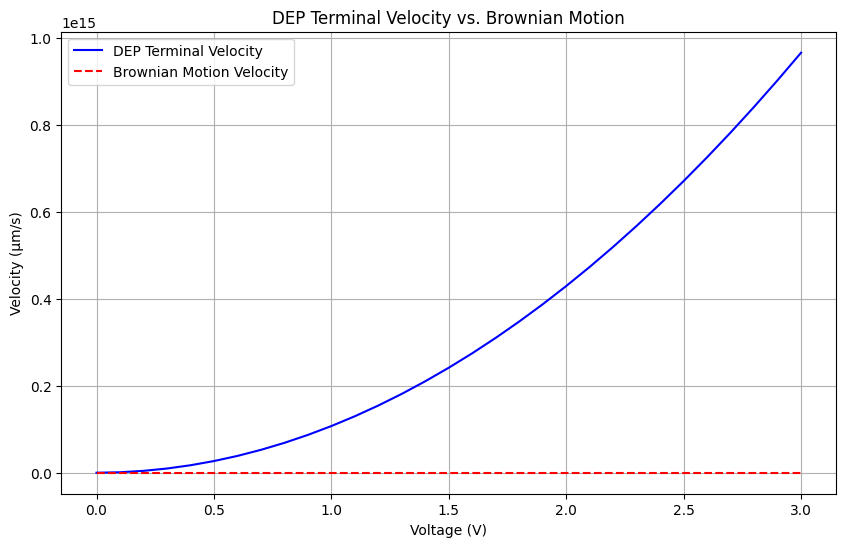

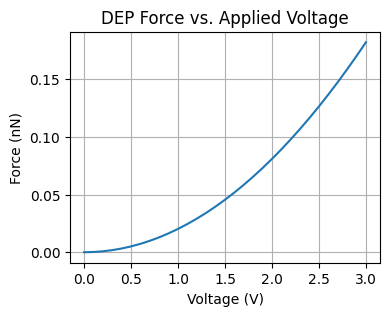

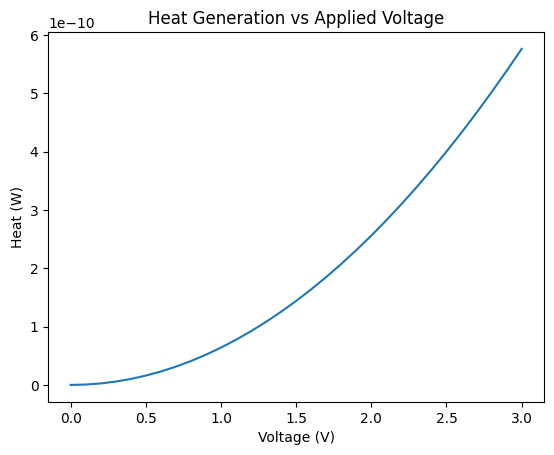

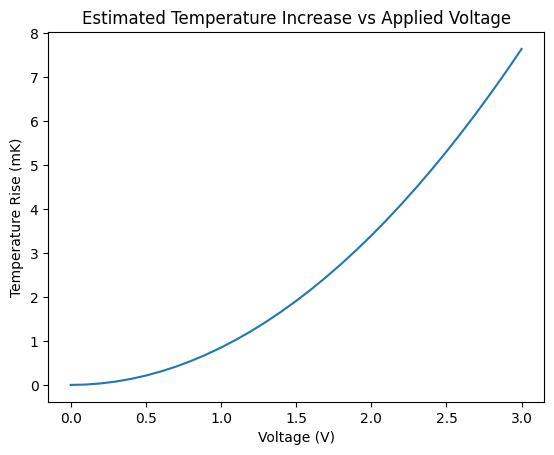

In [12]:
import numpy as np
import matplotlib.pyplot as plt
#parameter and units
gapSize  = 60 #nm
frequency = 1 # MHz
voltage_peak= 3 # V 
diameter = 20 # nm
waterDielectric = 78.5 # dielectric constant of water at 25C 

sigmaGold = 4.1e7 # conductivity of gold in S/m
sigmaWater = 0.055 # conductivity of water in S/m

K=(sigmaGold-sigmaWater)/(sigmaGold+2*sigmaWater) # clausious mossotti factor for spherical particles in a dielectric medium
print(f"Clausious Mossotti factor: {K:.4f}")
radius_m = diameter * 1e-9/2 # convert to meters
gapSize_m = gapSize * 1e-9 # convert to meters
particle_volume = (4/3) * 3.1415 * radius_m**3
E0= 8.854e-12 # permittivity of free space in F/m

volts=[]
force= []
heats = []
for v in np.arange(0, voltage_peak+0.1, 0.1):
    Fdep= 2*3.1415 * radius_m**3*waterDielectric*E0 *K* v**2/gapSize_m**3
    # Estimate Joule heating power dissipated in the volume occupied by the nanoparticle
    # assuming the conductivity of the surrounding water medium.
    # Power Density (W/m^3) = sigma * E^2
    # E = V/d = v / gapSize_m
    # Power (W) = Power Density * Volume
    
    electric_field_squared = (v / gapSize_m)**2
    heat = sigmaWater * electric_field_squared * particle_volume # Power in Watts
    heats.append(heat) # Power in Watts
    force.append(Fdep*1e9) # Convert force to nN
    volts.append(v)
    
# Calculate DEP terminal velocity
# Terminal velocity = F_DEP / (6*pi*eta*r)
# where eta is dynamic viscosity of water at room temp (1e-3 Pa·s)
viscosity_water = 1e-3  # Pa·s (water at room temp)
terminal_velocity = [f/(6*np.pi*viscosity_water*radius_m)*1e6 for f in force]  # Convert to µm/s

# Calculate Brownian motion characteristic velocity
# v_brownian = sqrt(kB*T/m)
# where kB is Boltzmann constant, T is temperature, m is particle mass
kB = 1.38064852e-23  # J/K
T = 298.15  # K (25°C)
density_gold = 19300  # kg/m³
mass = density_gold * particle_volume
brownian_velocity = np.sqrt(kB*T/mass) * 1e6  # µm/s
brownian_line = [brownian_velocity] * len(volts)

plt.figure(figsize=(10, 6))
plt.plot(volts, terminal_velocity, 'b-', label='DEP Terminal Velocity')
plt.plot(volts, brownian_line, 'r--', label='Brownian Motion Velocity')
plt.xlabel("Voltage (V)")
plt.ylabel("Velocity (µm/s)")
plt.title("DEP Terminal Velocity vs. Brownian Motion")
plt.legend()
plt.grid(True)
plt.show()

# Plot the force as well
plt.figure(figsize=(4, 3))
plt.plot(volts, force)
plt.xlabel("Voltage (V)")
plt.ylabel("Force (nN)")
plt.title("DEP Force vs. Applied Voltage")
plt.grid(True)
plt.show()

# Create the heat plot
plt.figure()
plt.plot(volts, heats)
plt.xlabel("Voltage (V)")
plt.ylabel("Heat (W)")
plt.title("Heat Generation vs Applied Voltage")

# Calculate temperature rise (approximate)
# Using the relationship: ΔT = P/(4πκr)
# where κ is thermal conductivity of water (0.6 W/m·K)
thermal_conductivity_water = 0.6  # W/m·K
temp_rise = [h/(4*np.pi*thermal_conductivity_water*radius_m) for h in heats]

# Create temperature rise plot
plt.figure()
plt.plot(volts, np.array(temp_rise) * 1000)  # Convert to milliKelvin for better scale
plt.xlabel("Voltage (V)")
plt.ylabel("Temperature Rise (mK)")
plt.title("Estimated Temperature Increase vs Applied Voltage")
plt.show()

In [ ]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive,
#@markdown try disabling your adblocker and run this cell again.
#@markdown  If that fails click on the little folder icon to the
#@markdown  left, navigate to file: `name.result.zip`,
#@markdown  right-click and select \"Download\"
#@markdown (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).
!zip -r {path}.result.zip outputs/{path}* outputs/traj/{path}*
files.download(f"{path}.result.zip")

**Instructions**
---
---

Use `contigs` to define continious chains. Use a `:` to define multiple contigs and a `/` to define mutliple segments within a contig.
For example:

**unconditional**
- `contigs='100'` - diffuse **monomer** of length 100
- `contigs='50:100'` - diffuse **hetero-oligomer** of lengths 50 and 100
- `contigs='50'` `symmetry='cyclic'` `order=2` - make two copies of the defined contig(s) and add a symmetry constraint, for **homo-oligomeric** diffusion.

**binder design**
- `contigs='A:50'` `pdb='4N5T'` - diffuse a **binder** of length 50 to chain A of defined PDB.
- `contigs='E6-155:70-100'` `pdb='5KQV'` `hotspot='E64,E88,E96'` - diffuse a **binder** of length 70 to 100 (sampled randomly) to chain E and defined hotspot(s).

**motif scaffolding**
 - `contigs='40/A163-181/40'` `pdb='5TPN'`
 - `contigs='A3-30/36/A33-68'` `pdb='6MRR'` - diffuse a loop of length 36 between two segments of defined PDB ranges.

**partial diffusion**
- `contigs=''` `pdb='6MRR'` - noise all coordinates
- `contigs='A1-10'` `pdb='6MRR'` - keep first 10 positions fixed, noise the rest
- `contigs='A'` `pdb='1SSC'` - fix chain A, noise the rest

*hints and tips*
- `pdb=''` leave blank to get an upload prompt
- `contigs='50-100'` use dash to specify a range of lengths to sample from